<a href="https://colab.research.google.com/github/joshuadollison/MAT421/blob/main/MAT421_16133_HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 11**
Joshua Dollison

MAT421-16133

4/6/2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# **1: Numerical Error and Instability**

The class text states that there are two main issues to consider with regard to integration schemes for ODEs: accuracy and stability. Accuracy refers to a scheme's ability to get close to the exact solution, which is usually unknown, as a function of the step size $h$.  When solving ODEs numerically, we replace continuous mathematical processes with discrete approximations, which introduces errors. These errors are primarily categorized as truncation errors. The local truncation error (LTE) refers to the error made in a single step of the numerical method, assuming all prior steps were exact. On the other hand, the global truncation error (GTE) accounts for the accumulation of errors over multiple steps. While LTE gives an indication of the method's step-by-step accuracy, GTE is a better measure of how far the numerical solution deviates from the true solution over an interval. To reduce these errors, higher-order methods such as Runge-Kutta are often used, as they incorporate more information at each step to yield more accurate approximations

The class text goes on to describe that previous chapters have referred to accuracy using the notation $O(h^p).$  The same notation translates to solving ODEs. The stability of an integration scheme is its ability to keep the error from growing as it integrates forward in time. If the error does not grow, then the scheme is stable; otherwise it is unstable. Some integration schemes are stable for certain choices of $h$ and unstable for others; these integration
schemes are also referred to as unstable.  Even when a method is accurate in theory, it may produce incorrect solutions if it is unstable. Instability arises when small errors, whether from rounding or truncation, grow uncontrollably as the computation proceeds. A stable method ensures that these small errors either diminish or remain bounded over time. The stability of a method depends not only on the algorithm itself but also on the properties of the differential equation and the choice of step size. For instance, the Euler method, although simple and widely used, is conditionally stable—it requires appropriately small step sizes to produce reliable results. In cases where the ODE is stiff, meaning that certain components evolve much more rapidly than others, special care must be taken to use stable numerical methods; otherwise, the solution may diverge dramatically.

---

### **Example 1.1**

In simple methods like Euler's method, too-large step sizes can cause errors to accumulate and even lead to unstable, diverging solutions.  This example implements the Euler method for a simple ODE $y'=-2y$ with $y(0)=1$. It then compares the numerical approximation with the exact solution $y=\exp(-2t)$ and plots both the solution and the global error.

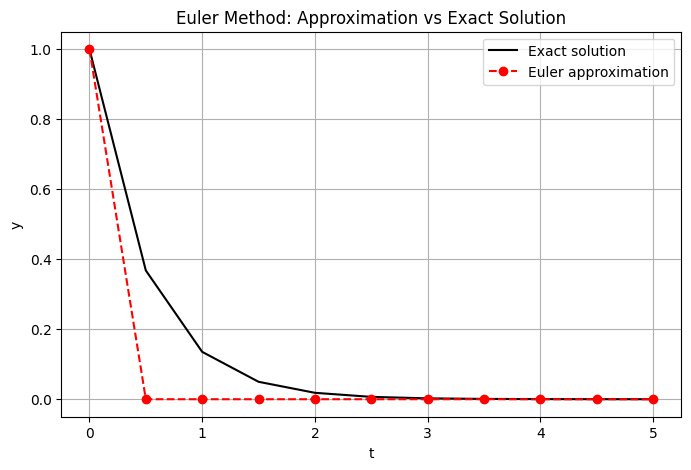

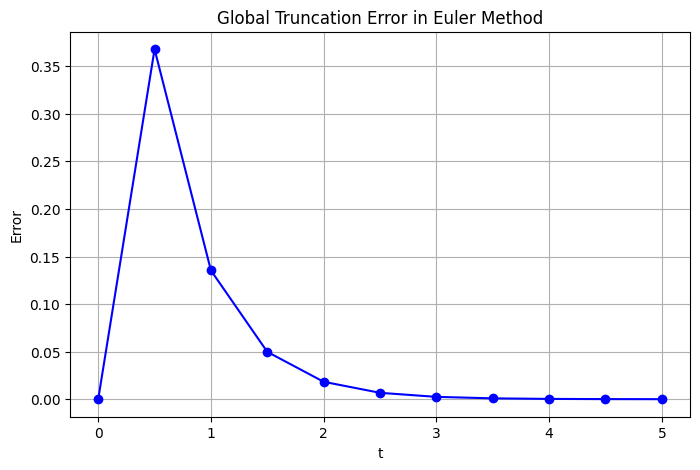

In [2]:
# Define the Euler method
def euler_method(f, y0, t):
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(1, len(t)):
        h = t[i] - t[i-1]
        y[i] = y[i-1] + h * f(t[i-1], y[i-1])
    return y

# ODE: y' = -2y
def f(t, y):
    return -2 * y

# Exact solution: y = exp(-2t)
def exact_solution(t):
    return np.exp(-2 * t)

# Time discretization parameters
t_end = 5
h = 0.5  # Step size (try modifying h to see stability effects)
t = np.arange(0, t_end + h, h)
y0 = 1.0

# Compute Euler approximation and exact solution
y_euler = euler_method(f, y0, t)
y_exact = exact_solution(t)

# Plot the approximate and exact solutions
plt.figure(figsize=(8,5))
plt.plot(t, y_exact, 'k-', label='Exact solution')
plt.plot(t, y_euler, 'ro--', label='Euler approximation')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Euler Method: Approximation vs Exact Solution')
plt.legend()
plt.grid(True)
plt.show()

# Plot the global truncation error
error = np.abs(y_euler - y_exact)
plt.figure(figsize=(8,5))
plt.plot(t, error, 'b-o')
plt.xlabel('t')
plt.ylabel('Error')
plt.title('Global Truncation Error in Euler Method')
plt.grid(True)
plt.show()

### **Example 1.2**

Numerical errors can be magnified in stiff equations if an inappropriate step size is chosen. For stiff ODEs, explicit methods like Euler's method may exhibit instability unless the time step is sufficiently small.  This GPT inspired real-world example applies the Euler method to the stiff ODE $y'=-15y$ (which has a rapidly decaying exact solution $y=\exp(-15t)$). With a large time step, instability is observed. For comparison, a stable solver from SciPy (using the Radau method) is employed to demonstrate a stable integration of the stiff problem.

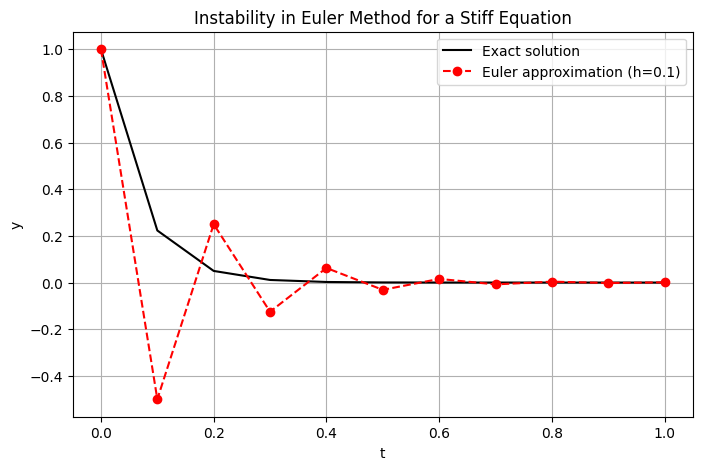

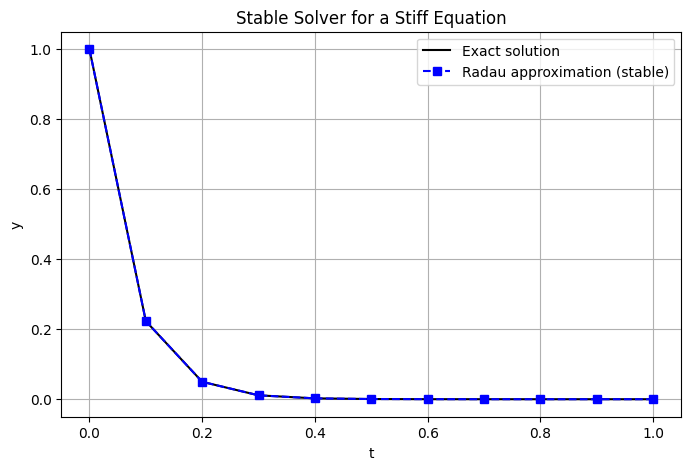

In [3]:
# Define stiff ODE: y' = -15y
def f_stiff(t, y):
    return -15 * y

# Time discretization for a stiff problem
t_end = 1.0
h_bad = 0.1  # A relatively large step size for this stiff ODE
t_bad = np.arange(0, t_end + h_bad, h_bad)
y0 = 1.0

# Compute Euler approximation (expected to be unstable)
y_euler_bad = euler_method(f_stiff, y0, t_bad)
exact = np.exp(-15 * t_bad)  # Exact solution

# Plot the unstable Euler approximation vs exact solution
plt.figure(figsize=(8,5))
plt.plot(t_bad, exact, 'k-', label='Exact solution')
plt.plot(t_bad, y_euler_bad, 'ro--', label='Euler approximation (h=0.1)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Instability in Euler Method for a Stiff Equation')
plt.legend()
plt.grid(True)
plt.show()

# Now, use a stable method from SciPy (Radau, suitable for stiff problems)
sol = solve_ivp(f_stiff, [0, t_end], [y0], method='Radau', t_eval=t_bad)
plt.figure(figsize=(8,5))
plt.plot(t_bad, exact, 'k-', label='Exact solution')
plt.plot(t_bad, sol.y[0], 'bs--', label='Radau approximation (stable)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Stable Solver for a Stiff Equation')
plt.legend()
plt.grid(True)
plt.show()

# **2: Predictor-Corrector Methods**

The class text states that predictor-corrector methods of solving initial value problems improve the approximation accuracy of non-predictor-corrector methods by querying the function several times at different locations (predictions), and then using a weighted average of the results (corrections) to update the state. Essentially it uses two formulas: the predictor and corrector. The predictor is an explicit formula and first estimates the solution at some point (we can use Euler method or some other methods to finish this step). After we obtain the solution, we can apply the corrector to improve the accuracy.  y iterating between prediction and correction, these methods enhance the reliability and accuracy of the solution, especially in problems where function evaluations are computationally expensive. Predictor-corrector methods strike a balance between efficiency and accuracy, making them valuable tools in numerical ODE solvers.

---

### **Example 2.1**

This example implements a basic predictor-corrector method to solve $y'=-2y$ with $y(0)=1.$. The predictor uses Euler's method while the corrector applies the trapezoidal rule. The numerical solution is compared against the exact solution $y=\exp(-2t)$ and plotted.

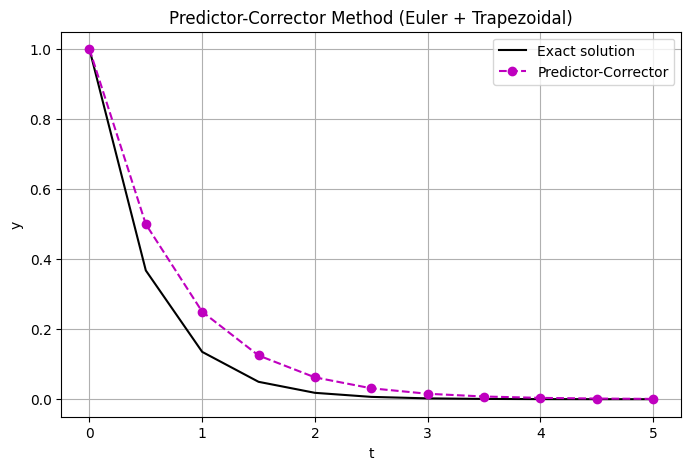

In [4]:
# Define the predictor-corrector method
def predictor_corrector(f, y0, t):
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(1, len(t)):
        h = t[i] - t[i-1]
        # Predictor: Euler's method
        y_pred = y[i-1] + h * f(t[i-1], y[i-1])
        # Corrector: Trapezoidal rule
        y[i] = y[i-1] + (h / 2) * (f(t[i-1], y[i-1]) + f(t[i], y_pred))
    return y

# ODE: y' = -2y (same as before)
def f(t, y):
    return -2 * y

# Exact solution: y = exp(-2t)
def exact_solution(t):
    return np.exp(-2 * t)

# Time discretization parameters
t_end = 5
h = 0.5
t = np.arange(0, t_end + h, h)
y0 = 1.0

# Compute the predictor-corrector solution and the exact solution
y_pc = predictor_corrector(f, y0, t)
y_exact = exact_solution(t)

# Plot the solutions
plt.figure(figsize=(8,5))
plt.plot(t, y_exact, 'k-', label='Exact solution')
plt.plot(t, y_pc, 'mo--', label='Predictor-Corrector')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Predictor-Corrector Method (Euler + Trapezoidal)')
plt.legend()
plt.grid(True)
plt.show()

### **Example 2.2**

This GPT inspired example applies a predictor-corrector method to a real-world scenario: modeling logistic growth in a population. The logistic differential equation $y' = r\,y\,(1 - y/K)$ (with$r=0.5$ and $K=100$) is solved using the predictor-corrector approach. The result is compared with a solution computed by SciPy's `solve_ivp` function, and both solutions are plotted.

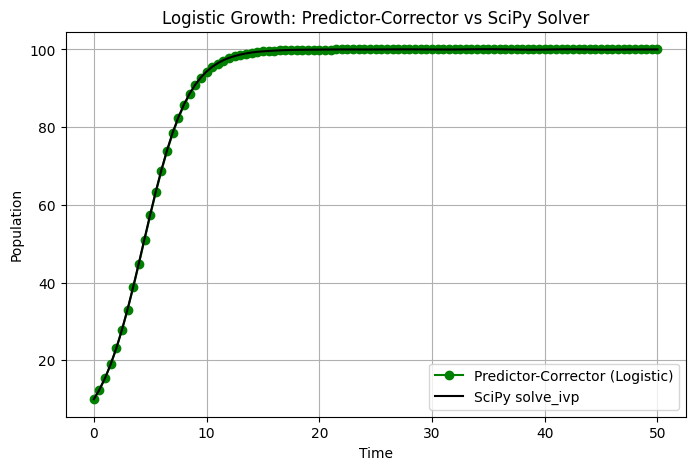

In [5]:
# Define the logistic ODE: y' = r * y * (1 - y/K)
def logistic_f(t, y, r=0.5, K=100):
    return r * y * (1 - y / K)

# Define a predictor-corrector method for the logistic equation
def predictor_corrector_logistic(f, y0, t, r=0.5, K=100):
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(1, len(t)):
        h = t[i] - t[i-1]
        # Predictor: Euler's method
        y_pred = y[i-1] + h * f(t[i-1], y[i-1], r, K)
        # Corrector: Trapezoidal rule
        y[i] = y[i-1] + (h / 2) * (f(t[i-1], y[i-1], r, K) + f(t[i], y_pred, r, K))
    return y

# Parameters for logistic growth
t_end = 50
h = 0.5
t = np.arange(0, t_end + h, h)
y0 = 10

# Compute the predictor-corrector solution for logistic growth
y_pc_logistic = predictor_corrector_logistic(logistic_f, y0, t, r=0.5, K=100)

# Solve the logistic equation using SciPy's solve_ivp for comparison
sol = solve_ivp(lambda t, y: logistic_f(t, y, r=0.5, K=100), [0, t_end], [y0], t_eval=t)

# Plot the logistic growth solutions
plt.figure(figsize=(8,5))
plt.plot(t, y_pc_logistic, 'g-o', label='Predictor-Corrector (Logistic)')
plt.plot(sol.t, sol.y[0], 'k-', label='SciPy solve_ivp')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Logistic Growth: Predictor-Corrector vs SciPy Solver')
plt.legend()
plt.grid(True)
plt.show()